# 2.4b Optimization of Weather CNN on Scaled Data Set

## Contents
### 1. Import libraries and data sets
### 2. Reshape data sets
### 3. Split data
### 4. Bayesian search optimization
### 5. Create RNN model on optimum
### 6. Confusion Matrix

## 1. Import libraries and data sets

In [63]:
!pip uninstall scikeras -y
!pip uninstall scikit-learn -y
!pip install scikeras
!pip install scikit-learn
!pip install bayesian-optimization

import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
# for the NotImplementedError
tf.config.run_functions_eagerly(True)
from numpy import unique
from numpy import reshape
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

# for optimization:
from sklearn.model_selection import cross_val_score
from keras.layers import Conv1D, Conv2D, BatchNormalization, Flatten, MaxPooling1D

# from keras.utils import np_utils
#import np_utils
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from google.colab import files
import io

Found existing installation: scikeras 0.13.0
Uninstalling scikeras-0.13.0:
  Successfully uninstalled scikeras-0.13.0
Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2
  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikeras-0.13.0-py3-none-any.whl (26 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)


In [2]:
# path = r'/Users/susanwang/Documents/CF_ML/ML_Project'
uploaded = files.upload()

Saving scaled_cleaned_weather.csv to scaled_cleaned_weather.csv


In [4]:
# weather_df = pd.read_csv(os.path.join(path, 'Data Sets', 'scaled_cleaned_weather.csv'), index_col=False)
weather_df = pd.read_csv(io.BytesIO(uploaded['scaled_cleaned_weather.csv']), index_col=False)

In [5]:
weather_df.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,BELGRADE_humidity,BELGRADE_pressure,BELGRADE_global_radiation,BELGRADE_precipitation,BELGRADE_sunshine,BELGRADE_temp_mean,BELGRADE_temp_min,BELGRADE_temp_max,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_sunshine,BUDAPEST_temp_mean,BUDAPEST_temp_min,BUDAPEST_temp_max,DEBILT_cloud_cover,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_sunshine,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DUSSELDORF_cloud_cover,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_sunshine,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_sunshine,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,LJUBLJANA_cloud_cover,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_sunshine,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,MAASTRICHT_cloud_cover,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_sunshine,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MADRID_cloud_cover,MADRID_humidity,MADRID_pressure,MADRID_global_radiation,MADRID_precipitation,MADRID_sunshine,MADRID_temp_mean,MADRID_temp_min,MADRID_temp_max,MUNCHENB_cloud_cover,MUNCHENB_humidity,MUNCHENB_global_radiation,MUNCHENB_precipitation,MUNCHENB_sunshine,MUNCHENB_temp_mean,MUNCHENB_temp_min,MUNCHENB_temp_max,OSLO_cloud_cover,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_pressure,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_sunshine,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,0.660514,0.826097,-0.001949,-1.101066,-0.265148,-0.902918,-0.528623,-0.845652,-0.478356,-1.206433,0.905270,0.321771,-0.743149,-0.371315,0.283983,-1.016876,-1.220210,-0.949203,-0.25524,-0.010098,-0.005876,-1.118537,-0.321868,-0.773378,-1.099163,-1.119431,-1.136839,0.713782,0.357839,-1.232471,-1.197013,0.049619,-1.077312,-0.114356,0.263326,-0.411047,1.232526,0.625746,-0.005606,-1.157575,-0.305938,-1.014908,-0.105836,0.060555,-0.410423,0.833387,1.332572,-1.376592,-1.187370,0.141032,-1.064721,-0.106469,0.393470,-1.038492,0.449867,-0.801741,-1.069690,0.747355,-0.647708,-0.182904,-0.251893,-0.466503,1.205492,1.864672,-0.008724,-1.203514,-0.406430,-1.149211,-1.370824,-1.125110,-1.578385,0.703568,0.267752,-1.043873,-1.052433,0.252496,-0.810834,-0.097084,0.382899,-0.387967,0.855172,1.887115,1.149046,-1.423735,-0.315682,-1.521762,-0.988280,-0.877723,-1.044732,-0.093824,-0.746542,-1.244144,-0.282933,-1.098059,-0.265742,-0.505735,-0.350849,1.111743,1.544023,-1.142400,-1.067870,1.925426,-1.018677,-0.186575,0.094958,-0.474865,-0.428835,-0.629430,0.095234,-1.244440,-0.649856,-0.550327,-0.124331,-0.170125,-0.063322,-0.060102,-0.003465,-1.079126,0.479131,-1.013295,-0.391072,-0.290439,-0.639538,-0.443701,0.761754,-1.299744,-0.806427,-0.088407,0.372147,-0.668215,-0.519743,-0.752237,1.205492,0.095234,1.544023
1,0.244897,0.735760,-0.001949,-1.058108,1.658760,-0.810

In [6]:
weather_df.shape

(22950, 135)

In [7]:
#answers_df = pd.read_csv(os.path.join(path, 'Data Sets', 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), index_col=False)
uploaded2 = files.upload()

Saving Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv to Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv


In [9]:
answers_df = pd.read_csv(io.BytesIO(uploaded2['Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv']), index_col=False)

In [10]:
answers_df.head()

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# remove date column
answers_df.drop(columns=['DATE'], inplace=True)

In [12]:
answers_df.head()

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
answers_df.shape

(22950, 15)

## 2. Reshape sets

Stations

In [14]:
stations = list()

columns = weather_df.columns.tolist()
for col in columns:
    name = col.split('_', 1)[0]
    if name not in stations:
        stations.append(name)

print(len(stations))
print(stations)

15
['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']


Observation types

In [15]:
observations = list()

for col in columns:
    name = col.split('_', 1)[1]
    if name not in observations:
        observations.append(name)

print(len(observations))
print(observations)

9
['cloud_cover', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']


In [16]:
weather_arr = np.array(weather_df)
weather_arr

array([[ 6.60513663e-01,  8.26096599e-01, -1.94863388e-03, ...,
         1.20549184e+00,  9.52340493e-02,  1.54402321e+00],
       [ 2.44896945e-01,  7.35759689e-01, -1.94863388e-03, ...,
         3.71461490e-01,  6.73187494e-02, -7.12373579e-01],
       [ 1.07613038e+00,  1.27778115e+00, -1.94863388e-03, ...,
         1.20549184e+00,  1.32454449e-01, -2.73629759e-01],
       ...,
       [-5.86336492e-01,  1.30644098e-02,  7.16401992e-01, ...,
        -8.79584032e-01, -1.43225559e-04,  7.29213258e-01],
       [-1.70719774e-01,  3.74412049e-01,  4.87141154e-01, ...,
        -8.79584032e-01, -1.43225559e-04,  1.29331245e+00],
       [-1.70719774e-01,  7.35759689e-01,  1.96744092e-01, ...,
        -8.79584032e-01, -1.43225559e-04,  1.48134552e+00]])

In [17]:
weather_arr.shape

(22950, 135)

In [18]:
# reshape dataset
X = weather_arr.reshape(-1, 15, 9)
X

array([[[ 6.60513663e-01,  8.26096599e-01, -1.94863388e-03, ...,
         -5.28623012e-01, -8.45651922e-01, -4.78356271e-01],
        [-1.20643263e+00,  9.05270489e-01,  3.21770762e-01, ...,
         -1.01687613e+00, -1.22021042e+00, -9.49202784e-01],
        [-2.55240242e-01, -1.00976762e-02, -5.87602906e-03, ...,
         -1.09916317e+00, -1.11943125e+00, -1.13683915e+00],
        ...,
        [ 9.52340493e-02, -1.24444008e+00, -6.49855996e-01, ...,
         -6.33220094e-02, -6.01023076e-02, -3.46465175e-03],
        [-1.07912619e+00,  4.79130672e-01, -1.01329461e+00, ...,
         -4.43700743e-01,  7.61754381e-01, -1.29974368e+00],
        [-8.06426690e-01, -8.84074022e-02,  3.72146925e-01, ...,
          1.20549184e+00,  9.52340493e-02,  1.54402321e+00]],

       [[ 2.44896945e-01,  7.35759689e-01, -1.94863388e-03, ...,
         -5.82945633e-01, -4.62450189e-01, -5.69988328e-01],
        [ 6.52845676e-01,  1.11911758e+00,  1.68378867e-02, ...,
         -1.10766931e+00, -8.18701592e

In [19]:
X.shape

(22950, 15, 9)

In [20]:
# reshape y set to (22950,)

In [21]:
y = np.array(answers_df)
y.shape

(22950, 15)

In [22]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'multilabel-indicator'

In [23]:
#Use argmax to get rid of on-hot encoding and supply the numerical value.
y2 = np.argmax(y, axis = 1)
print(y2.shape)
y2

(22950,)


array([0, 0, 0, ..., 0, 0, 0])

In [24]:
type_of_target(y2)

'multiclass'

## 3. Split data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, random_state=42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17212, 15, 9)
(5738, 15, 9)
(17212,)
(5738,)


## 4. Bayesian search optimization

In [27]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 15 # Correctly determine the number of unique classes
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)
print(timesteps)
print(input_dim)
print(n_classes)


15
9
15


In [28]:
# function for Bayesian search

def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']

    neurons = round(neurons)
    kernel = round(kernel)
    activation = activationL[round(activation)]
    # optimizer = optimizerD[optimizerL[round(optimizer)]]
    optimizer = optimizerL[round(optimizer)]
    batch_size = round(batch_size)

    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    def cnn_model():
        model = Sequential()
        model.add(Conv1D(neurons, kernel_size=kernel,activation=activation, input_shape=(timesteps, input_dim)))
        #model.add(Conv1D(32, kernel_size=1,activation='relu', input_shape=(timesteps, input_dim)))

        if normalization > 0.5:
            model.add(BatchNormalization())
        for i in range(layers1):
            model.add(Dense(neurons, activation=activation)) #(neurons, activation=activation))
        if dropout > 0.5:
            model.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            model.add(Dense(neurons, activation=activation))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(n_classes, activation='softmax')) #sigmoid softmax
        #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        return model


    es = EarlyStopping(monitor='accuracy', mode='max', verbose=2, patience=20)
    # Pass callbacks directly to KerasClassifier constructor
    nn = KerasClassifier(build_fn=cnn_model, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[es])
    # Explicitly set the estimator type for scikit-learn compatibility
    nn._estimator_type = "classifier"
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    # score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, error_score='raise').mean()
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold).mean() # Removed params argument
    # error_score = 'raise' suggested
    if np.isnan(score) or np.isinf(score):
        return -1e10
    return score

In [ ]:
start = time.time()
params ={
    'neurons': (10, 100),
    'kernel': (1, 3),
    'activation':(0, 9), #9
    'optimizer':(0,7), #7
    'learning_rate':(0.01, 1),
    'batch_size': (200, 1000), #(10, 50), #200, 1000
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_opt = BayesianOptimization(bay_area, params, random_state=42)
# init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
nn_opt.maximize(init_points=5, n_iter=4) #25
print('Search took %s minutes' % ((time.time() - start)/60))

|   iter    |  target   |  neurons  |  kernel   | activa... | optimizer | learni... | batch_... |  epochs   |  layers1  |  layers2  | normal... |  dropout  | dropou... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/25
43/43 - 5s - 123ms/step - accuracy: 0.6440 - loss: nan
Epoch 2/25
43/43 - 5s - 114ms/step - accuracy: 0.6440 - loss: nan
Epoch 3/25
43/43 - 4s - 95ms/step - accuracy: 0.6440 - loss: nan
Epoch 4/25
43/43 - 4s - 94ms/step - accuracy: 0.6440 - loss: nan
Epoch 5/25
43/43 - 5s - 113ms/step - accuracy: 0.6440 - loss: nan
Epoch 6/25
43/43 - 4s - 96ms/step - accuracy: 0.6440 - loss: nan
Epoch 7/25
43/43 - 4s - 95ms/step - accuracy: 0.6440 - loss: nan
Epoch 8/25
43/43 - 5s - 114ms/step - accuracy: 0.6440 - loss: nan
Epoch 9/25
43/43 - 5s - 118ms/step - accuracy: 0.6440 - loss: nan
Epoch 10/25
43/43 - 5s - 107ms/step - accuracy: 0.6440 - loss: nan
Epo

In [ ]:
nn_opt.max

{'target': np.float64(0.8851377703761246),
 'params': {'neurons': np.float64(84.9583270300339),
  'kernel': np.float64(1.6490875868195638),
  'activation': np.float64(2.9699181899183174),
  'optimizer': np.float64(1.4061447782345964),
  'learning_rate': np.float64(0.3312901442878955),
  'batch_size': np.float64(619.9729691926963),
  'epochs': np.float64(53.52967256103481),
  'layers1': np.float64(1.8880650884683932),
  'layers2': np.float64(2.489178850599538),
  'normalization': np.float64(0.3463096799551748),
  'dropout': np.float64(0.5159884295511006),
  'dropout_rate': np.float64(0.13042990882332198)}}

In [ ]:
optimum = nn_opt.max['params']
learning_rate = optimum['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
optimum['activation'] = activationL[round(optimum['activation'])]
optimum['batch_size'] = round(optimum['batch_size'])
optimum['epochs'] = round(optimum['epochs'])
optimum['layers1'] = round(optimum['layers1'])
optimum['layers2'] = round(optimum['layers2'])
optimum['neurons'] = round(optimum['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
optimum['optimizer'] = optimizerD[optimizerL[round(optimum['optimizer'])]]
optimum

{'neurons': 85,
 'kernel': np.float64(1.6490875868195638),
 'activation': 'softsign',
 'optimizer': <keras.src.optimizers.sgd.SGD at 0x794357be89e0>,
 'learning_rate': np.float64(0.3312901442878955),
 'batch_size': 620,
 'epochs': 54,
 'layers1': 2,
 'layers2': 2,
 'normalization': np.float64(0.3463096799551748),
 'dropout': np.float64(0.5159884295511006),
 'dropout_rate': np.float64(0.13042990882332198)}

## 5. Create CNN model on optimum

In [29]:
len(X_train[0])

15

In [30]:
len(X_train[0][0])

9

In [32]:
####Need to add learning rate to the optimizer type??
epochs = 54
batch_size = 620
#n_hidden = 32

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 15
layers1 = 2
layers2 = 2
activation = 'softsign'
kernel = 1
neurons = 85
normalization = 0.346
dropout = 0.515
dropout_rate = 0.1304
optimizer = 'SGD'

model = Sequential()
model.add(Conv1D(neurons, kernel_size=kernel, activation=activation, input_shape=(timesteps, input_dim)))
if normalization > 0.5:
    model.add(BatchNormalization())
for i in range(layers1):
    model.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    model.add(Dropout(dropout_rate, seed=123))
for i in range(layers2):
    model.add(Dense(neurons, activation=activation))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax')) #softmax sigmoid
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #binary_crossentropy

In [33]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/54
28/28 - 4s - 140ms/step - accuracy: 0.4946 - loss: 2.3473
Epoch 2/54
28/28 - 3s - 120ms/step - accuracy: 0.6436 - loss: 1.6851
Epoch 3/54
28/28 - 3s - 114ms/step - accuracy: 0.6440 - loss: 1.3393
Epoch 4/54
28/28 - 4s - 130ms/step - accuracy: 0.6439 - loss: 1.2279
Epoch 5/54
28/28 - 5s - 186ms/step - accuracy: 0.6440 - loss: 1.1751
Epoch 6/54
28/28 - 10s - 342ms/step - accuracy: 0.6458 - loss: 1.1444
Epoch 7/54
28/28 - 6s - 206ms/step - accuracy: 0.6499 - loss: 1.1238
Epoch 8/54
28/28 - 7s - 248ms/step - accuracy: 0.6533 - loss: 1.1081
Epoch 9/54
28/28 - 5s - 161ms/step - accuracy: 0.6568 - loss: 1.0954
Epoch 10/54
28/28 - 5s - 179ms/step - accuracy: 0.6604 - loss: 1.0851
Epoch 11/54
28/28 - 6s - 212ms/step - accuracy: 0.6633 - loss: 1.0762
Epoch 12/54
28/28 - 6s - 198ms/step - accuracy: 0.6647 - loss: 1.0681
Epoch 13/54
28/28 - 6s - 210ms/step - accuracy: 0.6658 - loss: 1.0608
Epoch 14/54
28/28 - 6s - 220ms/step - accuracy: 0.6690 - loss: 1.0537
Epoch 15/54
28/28 - 10s - 34

## 6. Confusion Matrix

In [34]:
locations = list({x.split("_")[0] for x in weather_df.columns if x not in ["MONTH", "DATE"]})
locations.sort()
locations

['BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA']

In [35]:
stations = {}
for i in range(len(locations)):
  stations[i] = locations[i]
stations

{0: 'BASEL',
 1: 'BELGRADE',
 2: 'BUDAPEST',
 3: 'DEBILT',
 4: 'DUSSELDORF',
 5: 'HEATHROW',
 6: 'KASSEL',
 7: 'LJUBLJANA',
 8: 'MAASTRICHT',
 9: 'MADRID',
 10: 'MUNCHENB',
 11: 'OSLO',
 12: 'SONNBLICK',
 13: 'STOCKHOLM',
 14: 'VALENTIA'}

In [36]:
#Turn y_test into one-hot format
ty=to_categorical(y_test)
print(ty)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [37]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(ty.shape)


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
(5738, 15)
(5738, 15)


In [38]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([stations[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([stations[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [40]:
# Evaluate
print(confusion_matrix(ty, y_pred))

Pred        BASEL  BELGRADE  MADRID
True                               
BASEL        3456       226       0
BELGRADE      568       524       0
BUDAPEST      124        89       1
DEBILT         38        44       0
DUSSELDORF     22         7       0
HEATHROW       60        20       2
KASSEL          8         3       0
LJUBLJANA      53         8       0
MAASTRICHT      8         1       0
MADRID        394        62       2
MUNCHENB        8         0       0
OSLO            3         1       1
STOCKHOLM       1         3       0
VALENTIA        1         0       0


In [41]:
# The matrix doesn't look right. The shape of the y_test and y_pred are correct, but the y_pred is only three stations.
# I will try the other matrix display

In [53]:
y_pred2 = pd.DataFrame(y_pred)
y_pred2 = y_pred2.astype('int32')
y_pred2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5734,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
y_test2= pd.DataFrame(ty)
y_test2 = y_test2.astype('int32')
y_test2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5734,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5735,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5736,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


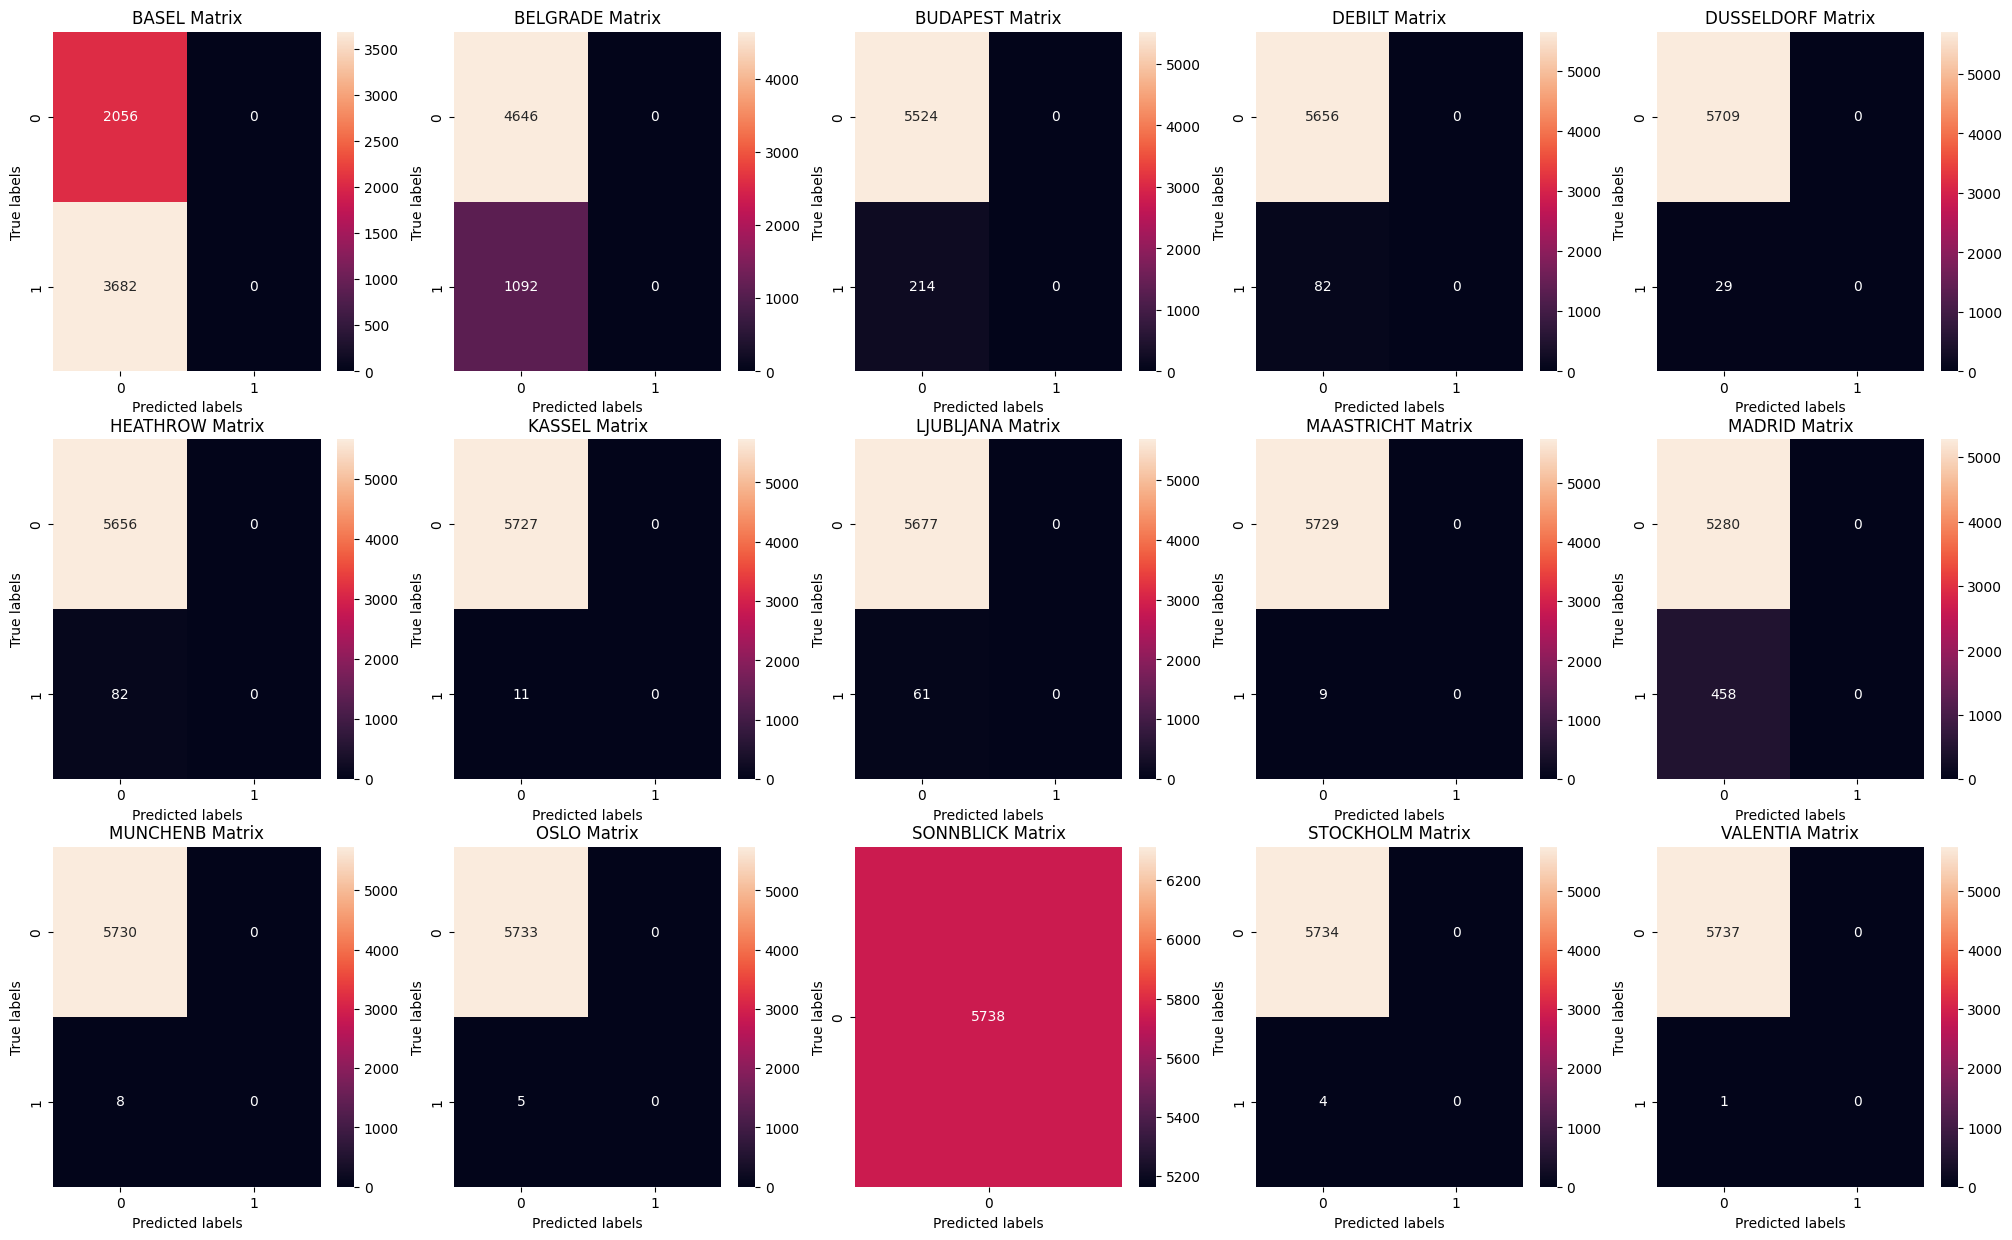

In [65]:
figure, ax = plt.subplots(3, 5, figsize=(25,15))
# labels = ['pleasant', 'unpleasant']
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        # cm = confusion_matrix(y_test_df.loc[:,name+key], y_pred[:,count])
        cm = confusion_matrix(y_test2.loc[:, count], y_pred2.loc[:, count])
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels');
        ax[i,j].set_title(name +' Matrix');
        #ax[i,j].xaxis.set_ticklabels(labels); #These two lines may throw an error depending on SONNBLICK data. Can you tell why?
        #ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

In [ ]:
# This matrix also shows that the model is working poorly, predicting no pleasant weather correctly.